<h1>Prova 2 - Introdução à Ciência dos Dados</h1>
<h3>Daniel Freitas Martins - 2304</h3>

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score

In [3]:
def lerCSV(caminho_arquivo, header):
    return pd.read_csv(caminho_arquivo, index_col=False, header=header, squeeze=True)

In [12]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
   
    if not title:
        if normalize:
            title = 'Matriz de Confusão normalizada'
        else:
            title = 'Matriz de Confusão NÃO normalizada'

    # calcula  a matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de Confusão normalizada")
    else:
        print('Matriz de Confusão NÃO normalizada')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ...criando os labels
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Entrada',
           xlabel='Saida')

    # rotacionando os labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Percorrendo sobre os dados e criando as anotações de texto
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

<h2>Lendo Dados-Prova02.csv, que contém informações de contratos de planos de assinatura de uma empresa de telecomunicações</h2>

In [4]:
df = lerCSV("Dados-Prova02.csv", header=0)
df.head(3)

,id-usuario,sexo,is-idoso,has-parceiro,has-dependentes,tempo-contrato-meses,has-servico-telefone,has-multiplas-linhas,servico-internet,has-seguranca-online,has-backup-online,has-protecao-dispositivo,has-suporte-tecnico,has-streaming-tv,has-streaming-filmes,tipo-contrato,has-pagamento-online,metodo-pagamento,valor-mensal,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,Yes


<h2>1) Faça uma análise exploratória dos dados, para conhecer melhor sobre os mesmos, seus
tipos, suas características, suas correlações, dentre outras informações que julgar necessárias e
importantes.</h2>

In [21]:
print(*df.columns, sep=', ')

id-usuario, sexo, is-idoso, has-parceiro, has-dependentes, tempo-contrato-meses, has-servico-telefone, has-multiplas-linhas, servico-internet, has-seguranca-online, has-backup-online, has-protecao-dispositivo, has-suporte-tecnico, has-streaming-tv, has-streaming-filmes, tipo-contrato, has-pagamento-online, metodo-pagamento, valor-mensal, Churn


Verificando os tipos das colunas.

In [23]:
print(df.dtypes)

id-usuario                   object
sexo                         object
is-idoso                      int64
has-parceiro                 object
has-dependentes              object
tempo-contrato-meses          int64
has-servico-telefone         object
has-multiplas-linhas         object
servico-internet             object
has-seguranca-online         object
has-backup-online            object
has-protecao-dispositivo     object
has-suporte-tecnico          object
has-streaming-tv             object
has-streaming-filmes         object
tipo-contrato                object
has-pagamento-online         object
metodo-pagamento             object
valor-mensal                float64
Churn                        object
dtype: object


Verificando se existem dados nulos.

In [28]:
print('Quantidade de registros nulos:', df.isnull().sum().max())
for col in df.columns:
    print(col, sum(pd.isnull(df[col])))

Quantidade de registros nulos: 0
id-usuario 0
sexo 0
is-idoso 0
has-parceiro 0
has-dependentes 0
tempo-contrato-meses 0
has-servico-telefone 0
has-multiplas-linhas 0
servico-internet 0
has-seguranca-online 0
has-backup-online 0
has-protecao-dispositivo 0
has-suporte-tecnico 0
has-streaming-tv 0
has-streaming-filmes 0
tipo-contrato 0
has-pagamento-online 0
metodo-pagamento 0
valor-mensal 0
Churn 0


Verificando os valores de cada coluna

In [32]:
for col in df.columns:
    print(col, df[col].unique())

id-usuario ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
sexo ['Female' 'Male']
is-idoso [0 1]
has-parceiro ['Yes' 'No']
has-dependentes ['No' 'Yes']
tempo-contrato-meses [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
has-servico-telefone ['No' 'Yes']
has-multiplas-linhas ['No' 'Yes']
servico-internet ['DSL' 'Fiber optic' 'No']
has-seguranca-online ['No' 'Yes']
has-backup-online ['Yes' 'No']
has-protecao-dispositivo ['No' 'Yes']
has-suporte-tecnico ['No' 'Yes']
has-streaming-tv ['No' 'Yes']
has-streaming-filmes ['No' 'Yes']
tipo-contrato ['Month-to-month' 'One year' 'Two year']
has-pagamento-online ['Yes' 'No']
metodo-pagamento ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
valor-mensal [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
Ch

Convertendo algumas colunas para tipos numéricos: Yes = 1; No = 0 e também Male = 1, Female = 0

In [35]:
df_convertido = df.copy()
df_convertido['sexo'] = [1 if x == 'Male' else 0 for x in df_convertido['sexo']]
cols_conversao = ['has-parceiro', 'has-dependentes', 'has-servico-telefone', 'has-multiplas-linhas',
                      'has-seguranca-online', 'has-backup-online', 'has-protecao-dispositivo',
                      'has-suporte-tecnico', 'has-streaming-tv', 'has-streaming-filmes',
                      'has-pagamento-online', 'Churn']

for col in cols_conversao:
    df_convertido[col] = [1 if x == 'Yes' else 0 for x in df_convertido[col]]
    
df_convertido.head(3)

,id-usuario,sexo,is-idoso,has-parceiro,has-dependentes,tempo-contrato-meses,has-servico-telefone,has-multiplas-linhas,servico-internet,has-seguranca-online,has-backup-online,has-protecao-dispositivo,has-suporte-tecnico,has-streaming-tv,has-streaming-filmes,tipo-contrato,has-pagamento-online,metodo-pagamento,valor-mensal,Churn
0,7590-VHVEG,0,0,1,0,1,0,0,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,29.85,0
1,5575-GNVDE,1,0,0,0,34,1,0,DSL,1,0,1,0,0,0,One year,0,Mailed check,56.95,0
2,3668-QPYBK,1,0,0,0,2,1,0,DSL,1,1,0,0,0,0,Month-to-month,1,Mailed check,53.85,1


Imprimindo pairplot.

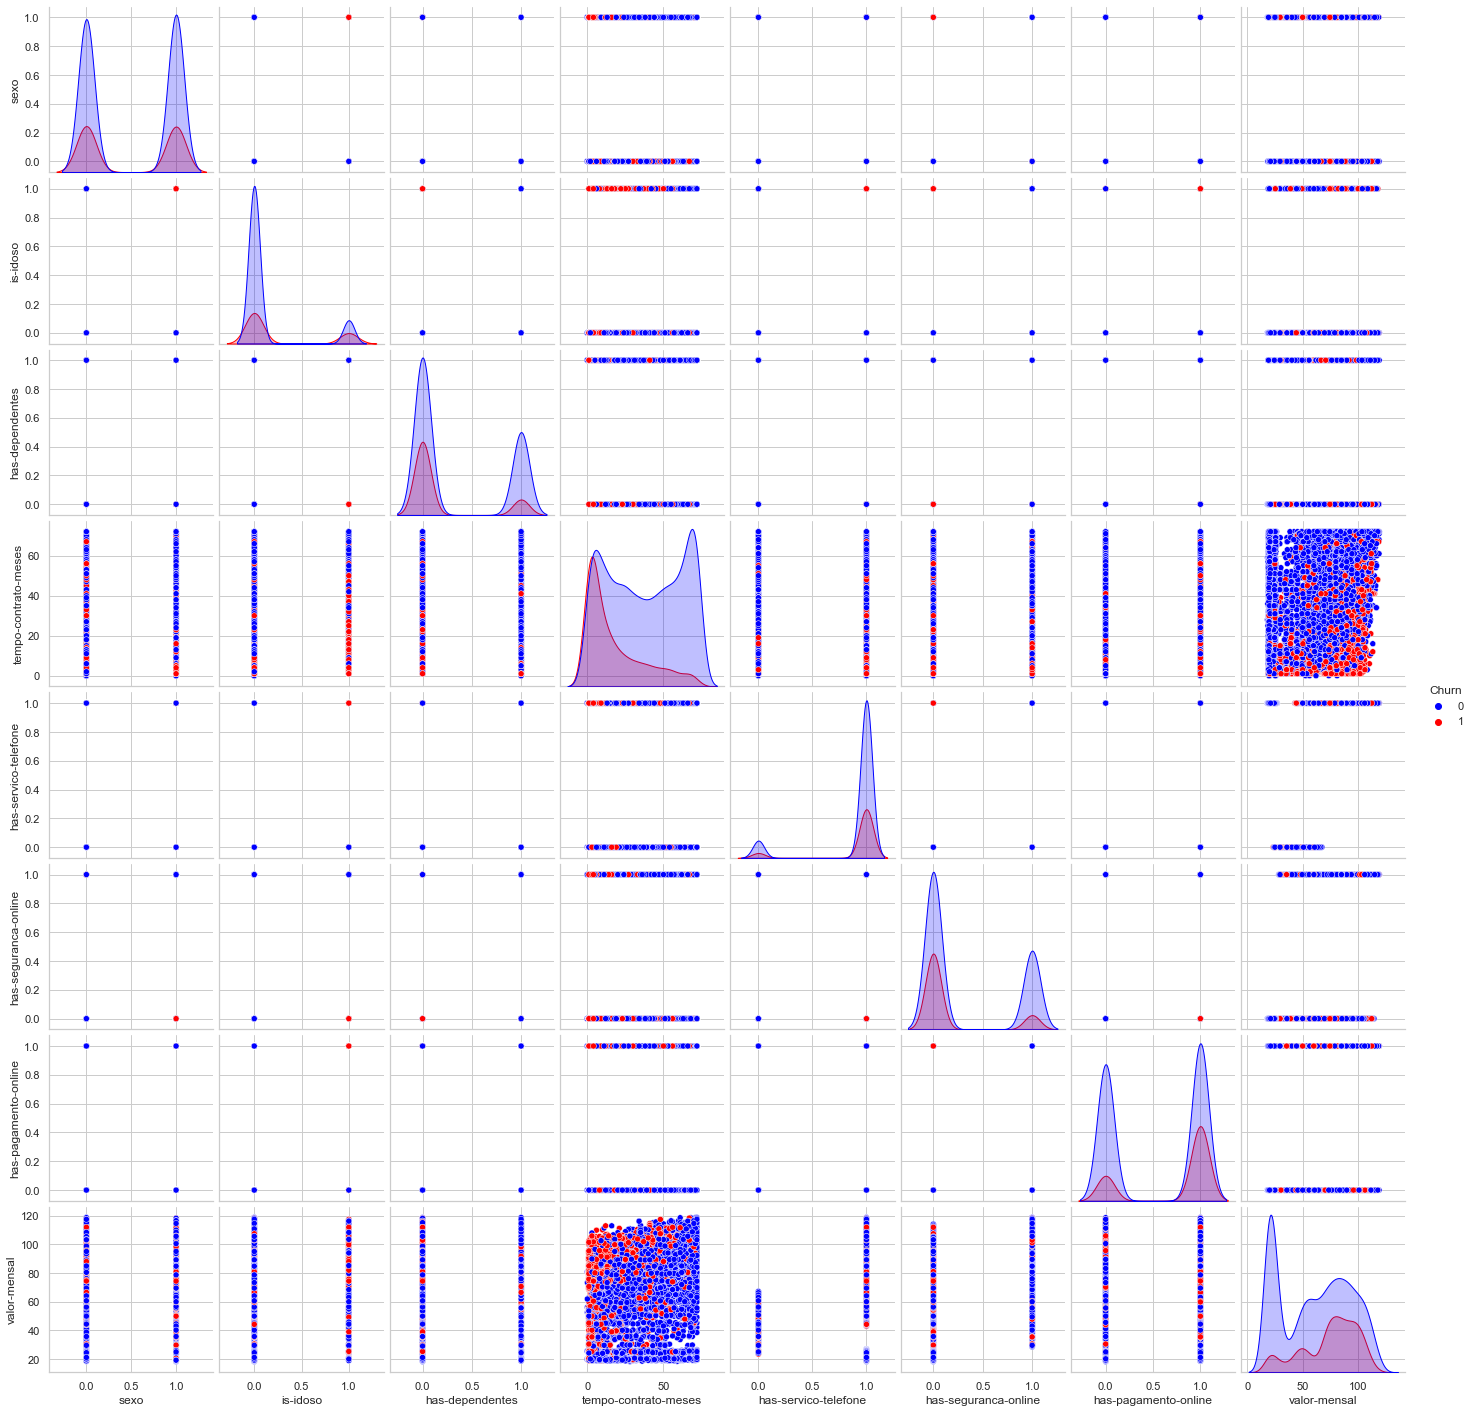

In [45]:
sns.set(style='whitegrid')
sns.pairplot(df_convertido[['Churn', 'sexo', 'is-idoso', 'has-dependentes', 'tempo-contrato-meses',
                           'has-servico-telefone', 'has-seguranca-online', 'has-pagamento-online', 
                            'valor-mensal']], hue='Churn', palette=['blue', 'red'])
plt.show()

In [80]:
def imprimirRelacionamentosChurn(df):
    qtd_registros = df['Churn'].count()
    qtd_cancelamentos = df[df['Churn'] == 1]['Churn'].count()
    qtd_ativos = df[df['Churn'] == 0]['Churn'].count()
    print('  Quantidade de registros:', qtd_registros)
    print('  Número de cancelamento de contratos:', qtd_cancelamentos)
    print('  Número de contratos não cancelados:', qtd_ativos)
    print('  Porcentagem do nº de contratos cancelados: %.2f%%' % (qtd_cancelamentos/qtd_registros*100))
    print('  Porcentagem do nº de contratos não cancelados: %.2f%%' % (qtd_ativos/qtd_registros*100))

In [90]:
def imprimirRelacionamentosChurnAux(coluna, titulo_0, titulo_1):
    x = coluna
    df_aux = df_convertido[[x, 'Churn']]

    sns.countplot(data=df_aux, x=x, hue='Churn')
    print(titulo_1)
    imprimirRelacionamentosChurn(df_aux[df_aux[x]==1])
    print('\n', titulo_0)
    imprimirRelacionamentosChurn(df_aux[df_aux[x]==0])

--- Pessoas do sexo Feminino ---
  Quantidade de registros: 3555
  Número de cancelamento de contratos: 930
  Número de contratos não cancelados: 2625
  Porcentagem do nº de contratos cancelados: 26.16%
  Porcentagem do nº de contratos não cancelados: 73.84%

 --- Pessoas do sexo Masculino ---
  Quantidade de registros: 3488
  Número de cancelamento de contratos: 939
  Número de contratos não cancelados: 2549
  Porcentagem do nº de contratos cancelados: 26.92%
  Porcentagem do nº de contratos não cancelados: 73.08%


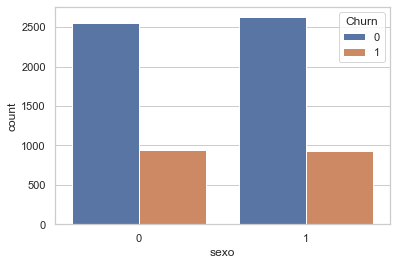

In [96]:
imprimirRelacionamentosChurnAux('sexo', '--- Pessoas do sexo Masculino ---', '--- Pessoas do sexo Feminino ---')

Veja que a porcentagem de contratos cancelados difere muito pouco em relação ao sexo da pessoa. Podemos inferir que o sexo da pessoa não influencia no número de cancelamento de contratos.

--- Pessoas não idosas ---
  Quantidade de registros: 1142
  Número de cancelamento de contratos: 476
  Número de contratos não cancelados: 666
  Porcentagem do nº de contratos cancelados: 41.68%
  Porcentagem do nº de contratos não cancelados: 58.32%

 --- Pessoas idosas ---
  Quantidade de registros: 5901
  Número de cancelamento de contratos: 1393
  Número de contratos não cancelados: 4508
  Porcentagem do nº de contratos cancelados: 23.61%
  Porcentagem do nº de contratos não cancelados: 76.39%


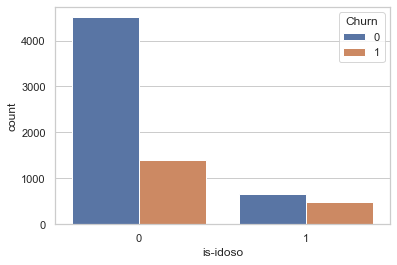

In [91]:
imprimirRelacionamentosChurnAux('is-idoso', '--- Pessoas idosas ---', '--- Pessoas não idosas ---')

--- Pessoas que não possuem serviço de telefone ---
  Quantidade de registros: 6361
  Número de cancelamento de contratos: 1699
  Número de contratos não cancelados: 4662
  Porcentagem do nº de contratos cancelados: 26.71%
  Porcentagem do nº de contratos não cancelados: 73.29%

 --- Pessoas que possuem serviço de telefone ---
  Quantidade de registros: 682
  Número de cancelamento de contratos: 170
  Número de contratos não cancelados: 512
  Porcentagem do nº de contratos cancelados: 24.93%
  Porcentagem do nº de contratos não cancelados: 75.07%


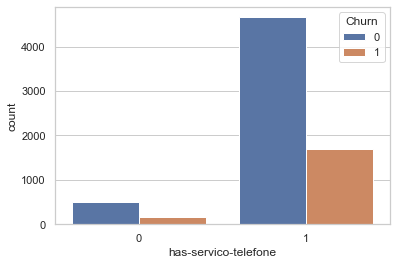

In [93]:
imprimirRelacionamentosChurnAux('has-servico-telefone', '--- Pessoas que possuem serviço de telefone ---', 
                                '--- Pessoas que não possuem serviço de telefone ---')

--- Pessoas que não possuem segurança online ---
  Quantidade de registros: 2019
  Número de cancelamento de contratos: 295
  Número de contratos não cancelados: 1724
  Porcentagem do nº de contratos cancelados: 14.61%
  Porcentagem do nº de contratos não cancelados: 85.39%

 --- Pessoas que possuem segurança online ---
  Quantidade de registros: 5024
  Número de cancelamento de contratos: 1574
  Número de contratos não cancelados: 3450
  Porcentagem do nº de contratos cancelados: 31.33%
  Porcentagem do nº de contratos não cancelados: 68.67%


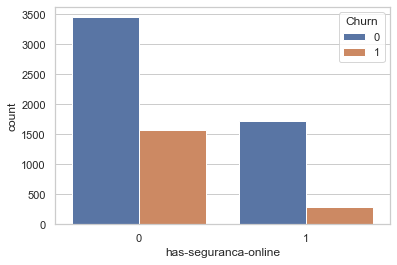

In [94]:
imprimirRelacionamentosChurnAux('has-seguranca-online', '--- Pessoas que possuem segurança online ---', 
                                '--- Pessoas que não possuem segurança online ---')

--- Pessoas que não possuem pagamento online ---
  Quantidade de registros: 4171
  Número de cancelamento de contratos: 1400
  Número de contratos não cancelados: 2771
  Porcentagem do nº de contratos cancelados: 33.57%
  Porcentagem do nº de contratos não cancelados: 66.43%

 --- Pessoas que possuem pagamento online ---
  Quantidade de registros: 2872
  Número de cancelamento de contratos: 469
  Número de contratos não cancelados: 2403
  Porcentagem do nº de contratos cancelados: 16.33%
  Porcentagem do nº de contratos não cancelados: 83.67%


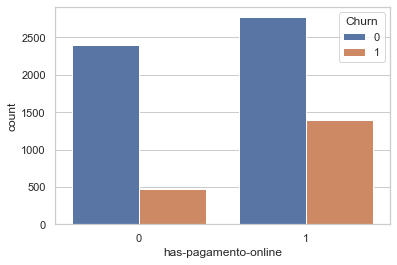

In [95]:
imprimirRelacionamentosChurnAux('has-pagamento-online', '--- Pessoas que possuem pagamento online ---', 
                                '--- Pessoas que não possuem pagamento online ---')

In [ ]:
imprimirRelacionamentosChurnAux('tempo-contrato-meses', '--- Pessoas que possuem dependentes ---', 
                                '--- Pessoas que não possuem dependentes ---')

Observando-se o pairplot acima e as outras informações mostradas, podemos observar o seguinte:
<ol>
    <li>As pessoas do sexo masculino e as pessoas do sexo feminino tendem a ter o mesmo comportamento em relação ao cancelamento de contratos (Churn). Este resultado é bastante curioso e indica que o sexo da pessoa não determina se ela irá cancelar ou não um contrato.</li>
    <li>As pessoas mais jovens tendem a cancelar menos os contratos do que as pessoas mais velhas. Dos idosos, aproximadamente 42% cancelaram os contratos, enquanto que dos jovens, aproximadamente 24% cancelaram os contratos.</li>
    <li></li>
</ol>

In [ ]:
sns.set(style='whitegrid')
sns.pairplot(df_convertido[['Churn', '']], hue='Churn', palette=['blue', 'red'])
plt.show()